In [1]:
import pandas as pd
import numpy as sns
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_excel('doc_comment_summary.xlsx',
                     header=None)
data.columns = ["text", "sentiment"]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26873 entries, 0 to 26872
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       26798 non-null  object
 1   sentiment  26850 non-null  object
dtypes: object(2)
memory usage: 420.0+ KB


In [4]:
data.describe()

,text,sentiment
count,26798,26850
unique,15374,17
top,"немецких войск и их союзников, а в плен попало...",0
freq,49,13930


<Axes: xlabel='sentiment'>

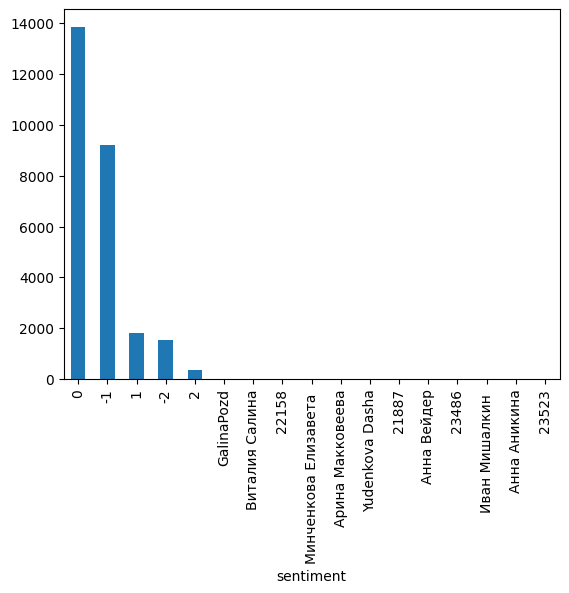

In [5]:
data.dropna()["sentiment"].value_counts().plot.bar()

In [6]:
# оставляем только данные с числовыми значениями в столбце с тональностью
clean_data_mask = data["sentiment"].isin([-2, -1, 1, 2])

In [7]:
data_clean = data[clean_data_mask].dropna().copy()
data_clean["sentiment"] = data_clean["sentiment"].astype(float)

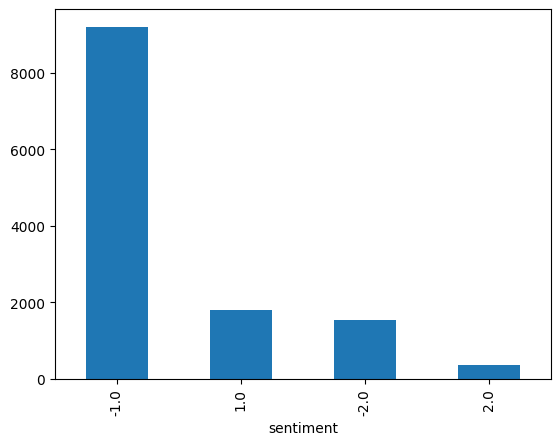

In [8]:
ax = data_clean["sentiment"].value_counts().plot.bar()
ax.set_label("Тональность")

In [9]:
data_clean["positive_sentiment"] = data_clean["sentiment"] > 0

In [10]:
data_clean["positive_sentiment"].value_counts()

positive_sentiment
False    10735
True      2159
Name: count, dtype: int64

In [11]:
# разбиваем выборку на рачабочую части и отложенную
X_train_test, X_holdout, y_train_test, y_holdout = train_test_split(data_clean["text"],
                                                                    data_clean["positive_sentiment"], test_size=0.1, random_state=42)

In [12]:
X_train_test

11768    ришли две женщины с пакетом, в котором была че...
12055    Молодец, чувак! А дегенеративную гниль поравал...
2306     олучается что Сочи пока подвис в воздухе и жде...
16816    Вообще южнее Тулы и Липецка. Об этом писал еще...
6892     бил. Но там был еще довершающий удар кого-то и...
                               ...                        
25008    09.2013). \tВ 2010г Маккейн  заявил  … нам над...
11046    ыло бы тебя 10 гигочеловек они бы здоровались ...
11499    )   видно что да.  да, бедные, несчастные, но ...
1977     Блядство vs  ПроституцияБлядство за деньги - н...
15164    Пользователь  сослался на вашу запись в записи...
Name: text, Length: 11604, dtype: object

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [14]:
pipeline_baseline = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", LogisticRegression())
    ])
pipeline_baseline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', LogisticRegression())])

In [15]:
_ = pipeline_baseline.fit(X_train_test, y_train_test )

In [16]:
y_holdout_pred = pipeline_baseline.predict(X_holdout)
baseline_score = accuracy_score(y_pred=y_holdout_pred, y_true=y_holdout)

In [17]:
baseline_score

0.8542635658914729

In [18]:
#Подстройка модели

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 1.0, 5),
    "vect__min_df": (1, 3, 5)
}

In [21]:
grid_search = GridSearchCV(
    estimator=pipeline_baseline,
    param_grid=parameter_grid, cv=2
)

In [22]:
_ = grid_search.fit(X_train_test, y_train_test)

In [23]:
grid_search.best_params_

{'vect__max_df': 1.0, 'vect__min_df': 5}

In [24]:
y_holdout_tuned_vect_pred = grid_search.best_estimator_.predict(X_holdout)
baseline_tuned_vect_score = accuracy_score(y_pred=y_holdout_tuned_vect_pred, y_true=y_holdout)

In [25]:
#Подбор модели

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [27]:
pipeline_rf = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", RandomForestClassifier())
    ])
pipeline_rf

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', RandomForestClassifier())])

In [28]:
pipeline_dtc = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", DecisionTreeClassifier())
    ])
pipeline_dtc

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', DecisionTreeClassifier())])

In [29]:
parameter_grid_rf = {
    "vect__max_df": (0.2, 0.4, 1.0, 5),
    "vect__min_df": (1, 3, 5),
    "clf__n_estimators": (10, 50),
    "clf__max_depth": (3, 4, 5)
}
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=parameter_grid_rf, cv=2
)

In [30]:
_ = grid_search_rf.fit(X_train_test, y_train_test)
grid_search_rf.best_params_

{'clf__max_depth': 4,
 'clf__n_estimators': 10,
 'vect__max_df': 1.0,
 'vect__min_df': 5}

In [31]:
y_holdout_tuned_rf_pred = grid_search_rf.best_estimator_.predict(X_holdout)
baseline_tuned_rf_score = accuracy_score(y_pred=y_holdout_tuned_rf_pred, y_true=y_holdout)

In [32]:
baseline_tuned_rf_score

0.8232558139534883

In [33]:
parameter_grid_dtc = {
    "vect__max_df": (0.2, 0.4, 1.0, 5),
    "vect__min_df": (1, 3, 5),
    "clf__max_depth": (3, 4, 5, 10, 15)
}
grid_search_dtc = GridSearchCV(
    estimator=pipeline_dtc,
    param_grid=parameter_grid_dtc, cv=2
)

In [34]:
pipeline_dtc = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", DecisionTreeClassifier())
    ])
pipeline_dtc

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', DecisionTreeClassifier())])

In [35]:
_ = grid_search_dtc.fit(X_train_test, y_train_test)
grid_search_dtc.best_params_

{'clf__max_depth': 10, 'vect__max_df': 0.2, 'vect__min_df': 5}

In [36]:
y_holdout_tuned_dct_pred = grid_search_dtc.best_estimator_.predict(X_holdout)
baseline_tuned_dct_score = accuracy_score(y_pred=y_holdout_tuned_dct_pred, y_true=y_holdout)

In [37]:
baseline_tuned_dct_score

0.8418604651162791